In [34]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from subprocess import Popen,PIPE
import sys
from scipy.signal import savgol_filter
from multiprocessing import Process

'''
1. make like the energyTemp stuff
2. run program from python
3. run more than just one instance in parrall to save time i guess
4. 2 or 4 processes need to give the machine more resouces
'''
basicDataLocation = '/home/cm/CLionProjects/MoleDymCode/AData/Clusters'

#those functions just save the data and then look at it
def dataPlotterEnergyTemperatur(layerID):
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/temperaturEnergyCurve" + str(layerID) + ".png"
    #open file
    file = open(energyFileLocation,'r')

    #read from the file
    text = file.readlines()
    energy = []
    for line in text:
        energy.append(float(line[:-1]))
    
    file.close()

    #open file
    file = open(temperaturFileLocation,'r')

    #read from the file
    text = file.readlines()
    temperatur = []
    for line in text:
        temperatur.append(float(line[:-1]))
    
    file.close()
    
    #plot
    plt.plot(temperatur,energy)
    plt.grid()
    plt.xlabel("Temperatur in K")
    plt.ylabel("Energy in eV")
    plt.savefig(imageSafeLocation)
    plt.show()
    
def dataPlotterKineticEnergy(layerID):
    #open file
    filelocation = basicDataLocation + "/kineticEnergy" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/kineticEnergyCurve" + str(layerID) + ".png"
    file = open(filelocation,'r')
    #read from the file
    text = file.readlines()
    kineticEnergy = []
    for line in text:
        kineticEnergy.append(float(line[:-1]))

    file.close()
    #create time array
    timestep = 1
    lenght = len(kineticEnergy)
    time = np.arange(start = 0, stop = timestep*lenght, step = timestep)
    #filter data couse this looks way to messy
    df = pd.DataFrame(dict(x=kineticEnergy))
    kineticEnergyFiltered = df[["x"]].apply(savgol_filter, window_length=1001, polyorder=2)

    #plot
    plt.ion()
    plt.rcParams['figure.figsize'] = [16,9]    
    #plt.plot(time,potentialEnergy)
    plt.plot(time,kineticEnergy)
    plt.plot(kineticEnergyFiltered,'r')
    plt.xlabel("Time in fs")
    plt.ylabel("Energy in eV")
    plt.grid()
    plt.savefig(imageSafeLocation)
    plt.show()
    

def functionCall(layerID):
    #file locations
    programbasePath = "/home/cm/CLionProjects/MoleDymCode/cmake-build-release/"
    programName = "myproject"
    programCall = programbasePath + programName

    #call the c++ program 
    process = Popen([programCall,str(layerID)],stdout = PIPE, stderr= PIPE)
    Popen.wait(process)
    stdout, stderr = process.communicate()
    print(stdout)
    print(stderr)

def combinedFunction(layerID):
    print("Working on Cluster " + str(layerID) + "\n")
    functionCall(layerID)
    #dataPlotterKineticEnergy(layerID)
    #dataPlotterEnergyTemperatur(layerID)

def plotter():
    for layerID in range(14-3+1):
        dataPlotterKineticEnergy(layerID+3)
        dataPlotterEnergyTemperatur(layerID+3)
    
def callInParralel(valueArray):
    for v in valueArray:
        combinedFunction(v)
        #print("Working on Cluster " + str(v)+"\n")

def dataMaker():
    start = time.time()        
    #create Patterns
    callPattern1 = np.array([3,4,12])
    callPattern2 = np.array([5,6,11])
    callPattern3 = np.array([8,9])
    callPattern4 = np.array([7,10])
    callPattern5 = np.array([13])
    callPattern6 = np.array([14])
    #create Processes
    process1 = Process(target = callInParralel, args =(callPattern1,))
    process2 = Process(target = callInParralel, args =(callPattern2,))
    process3 = Process(target = callInParralel, args =(callPattern3,))
    process4 = Process(target = callInParralel, args =(callPattern4,))
    process5 = Process(target = callInParralel, args =(callPattern5,))
    process6 = Process(target = callInParralel, args =(callPattern6,))

    #start processes
    process1.start()
    process2.start()
    process3.start()
    process4.start()
    process5.start()
    process6.start()

    #wait till end
    process1.join()
    process2.join()
    process3.join()
    process4.join()
    process5.join()
    process6.join()
    
    #
    end = time.time()
    print("Done in")
    print(end - start)

def readClusterSizes(layerID):
    #reads the first line form the clusters which contains the number of Atoms
    clusterFile = basicDataLocation + "cluster"
    
    


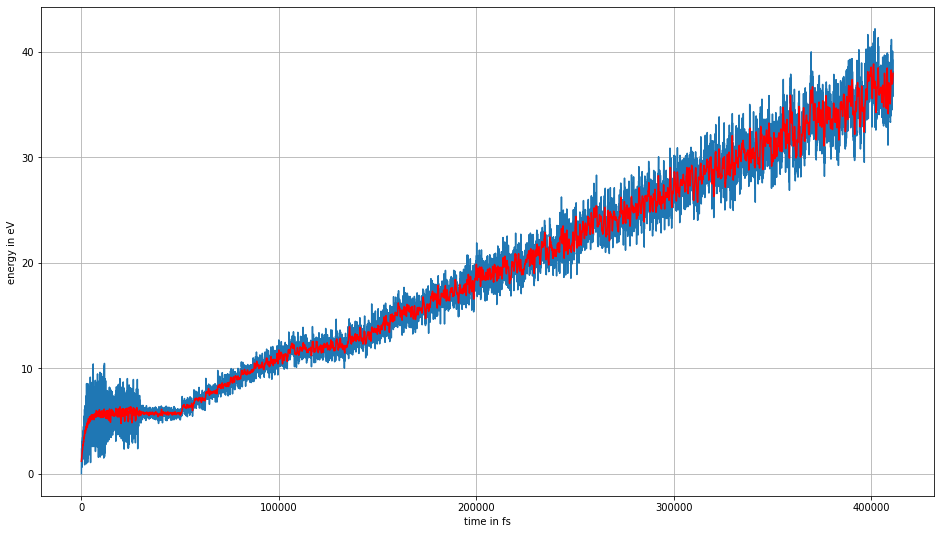

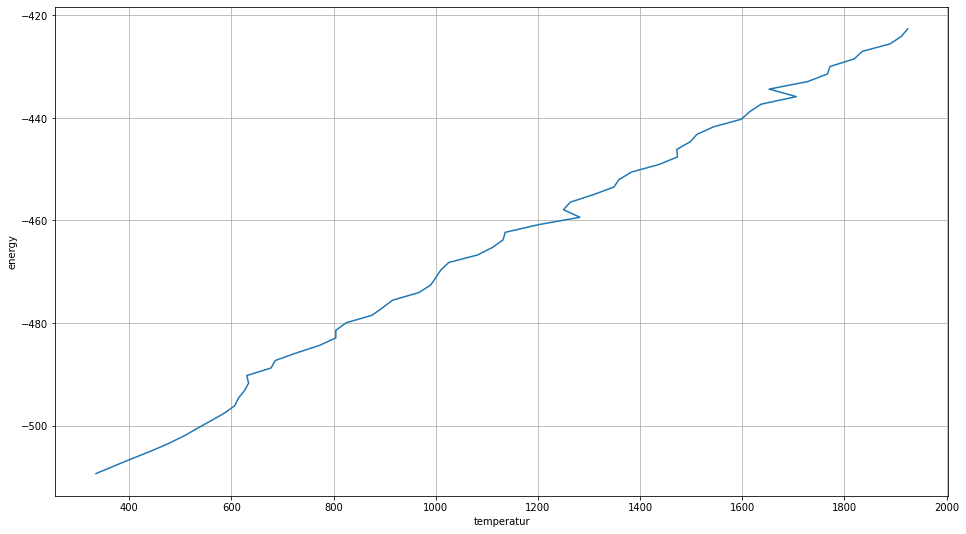

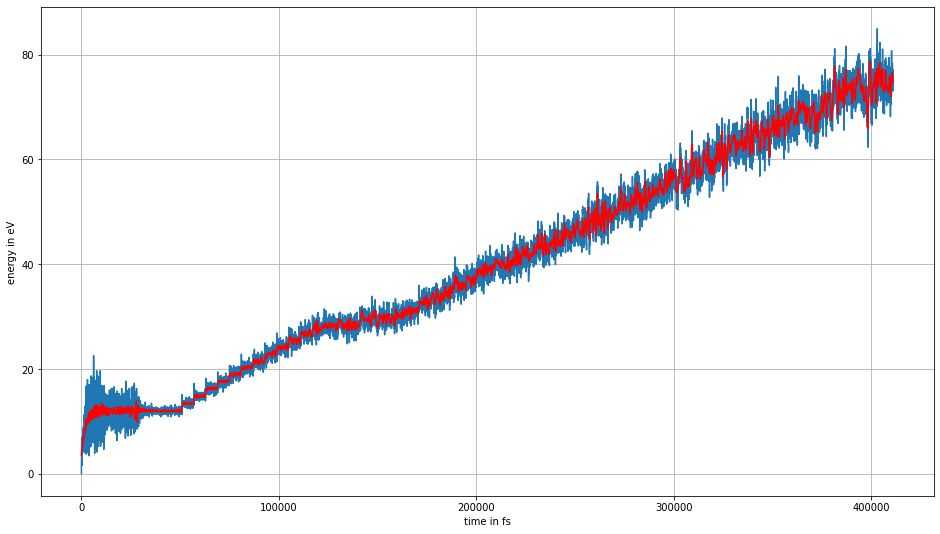

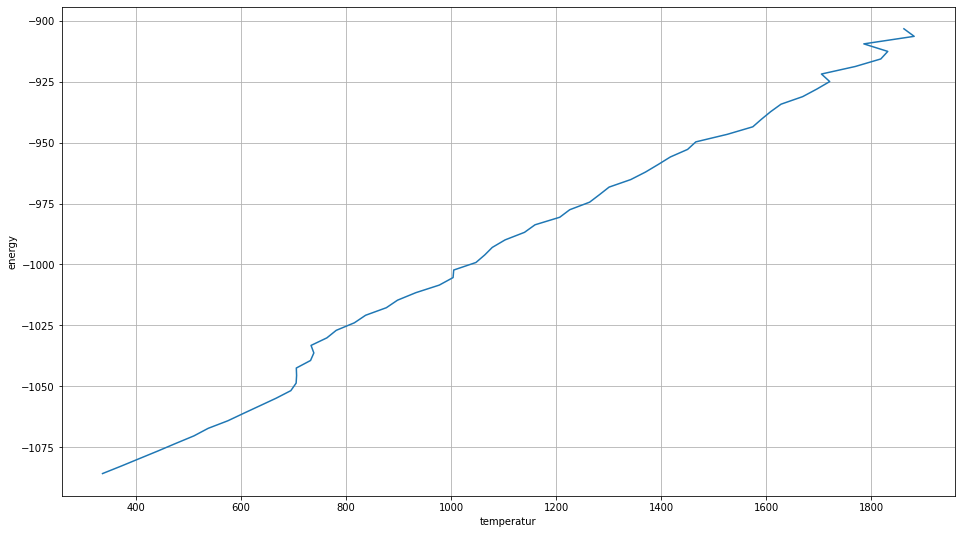

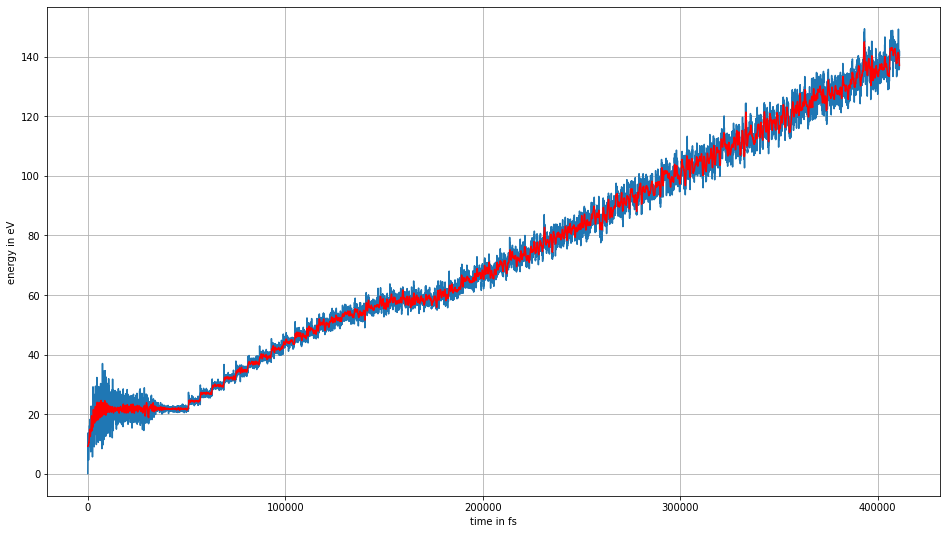

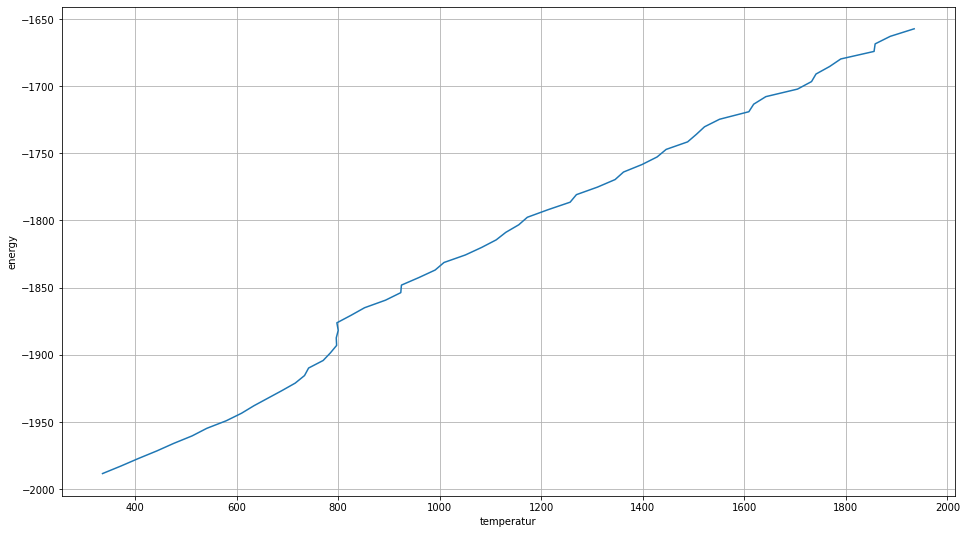

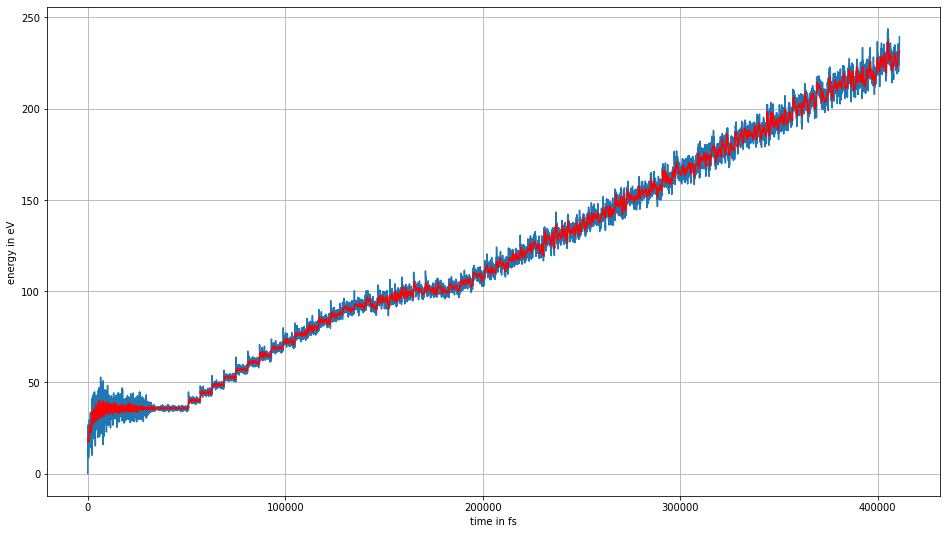

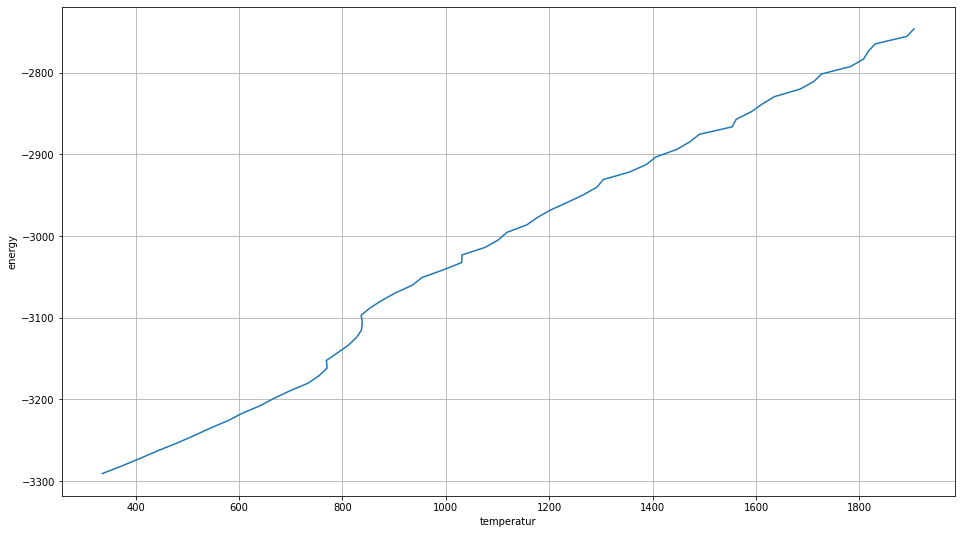

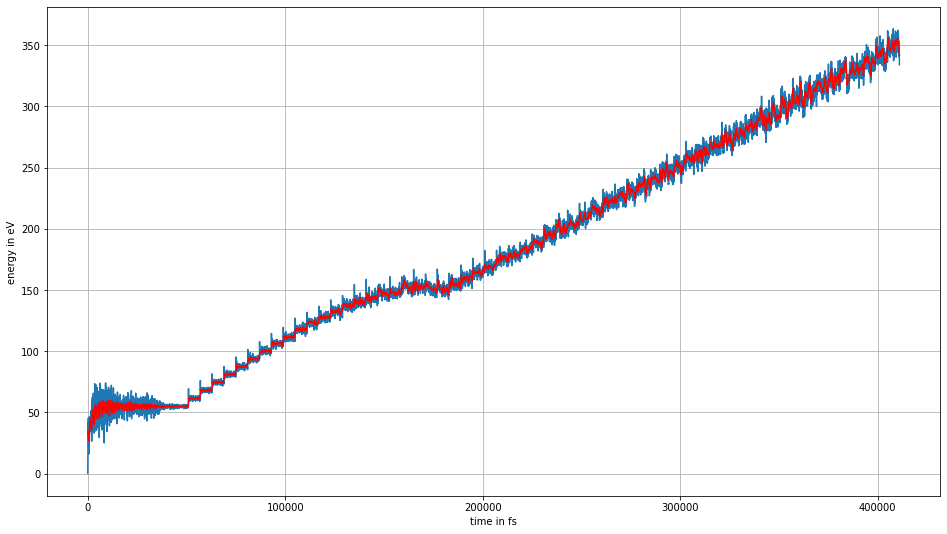

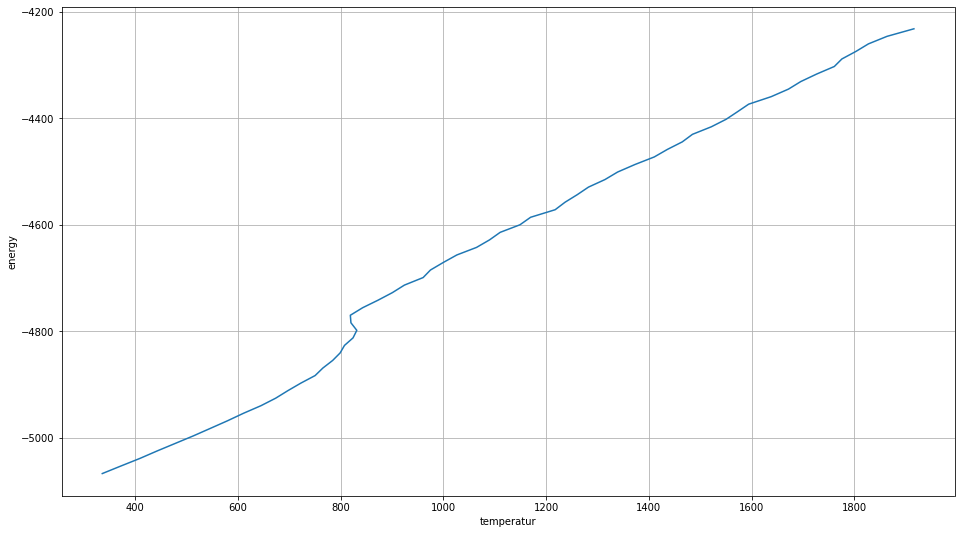

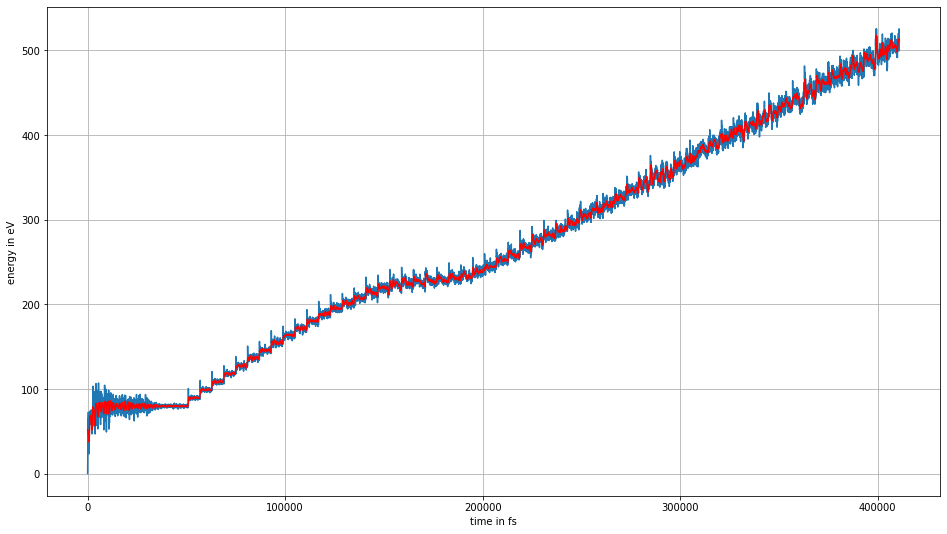

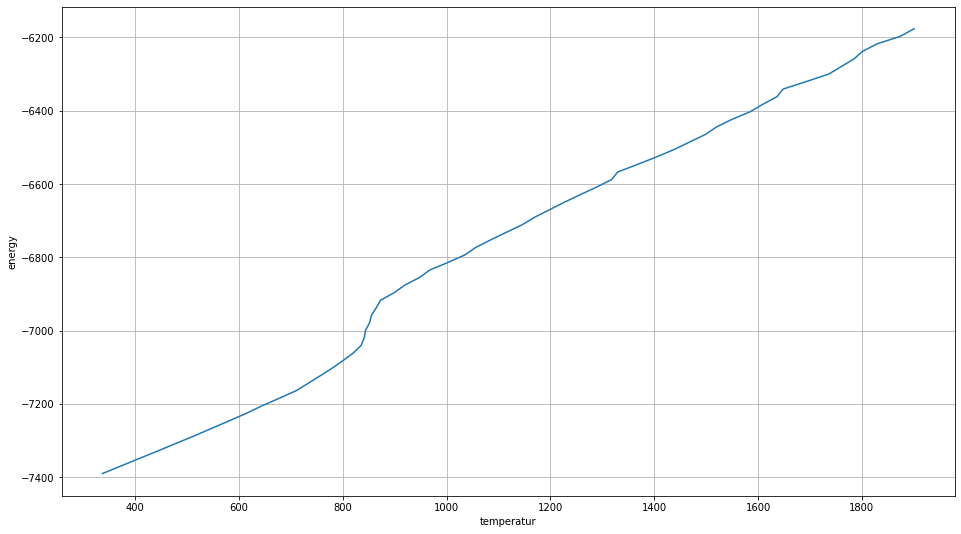

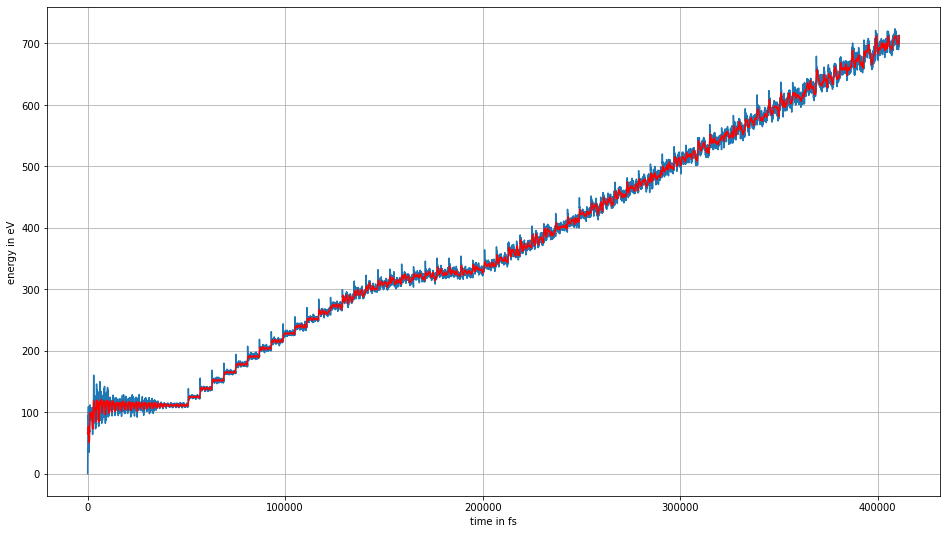

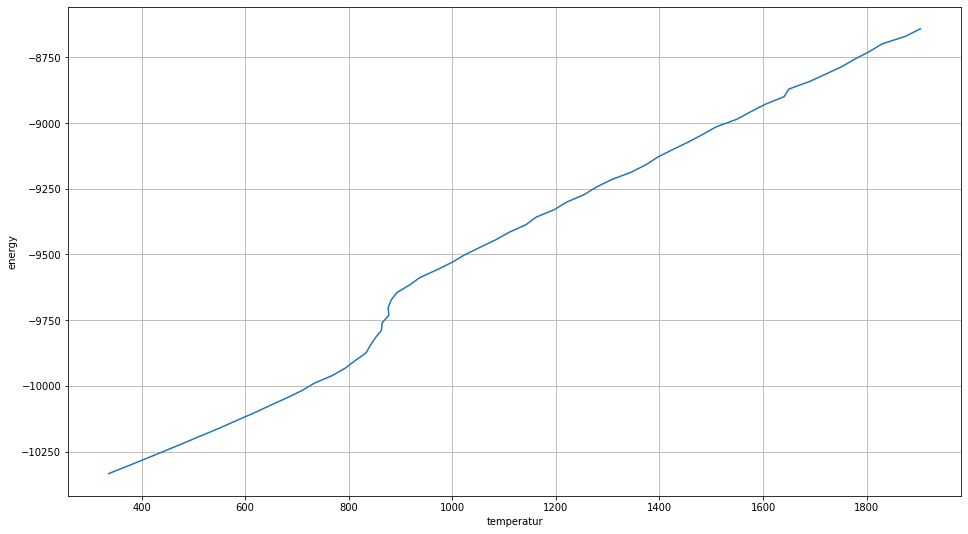

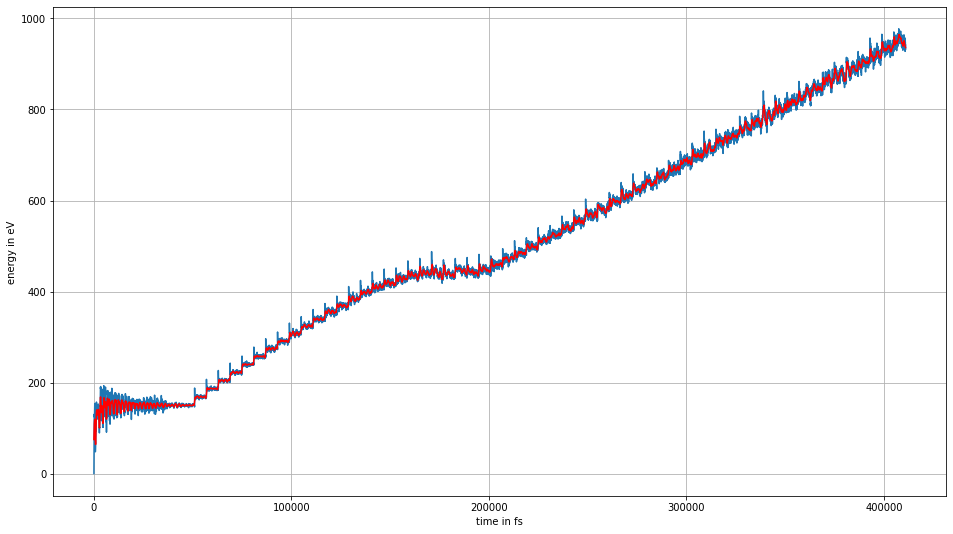

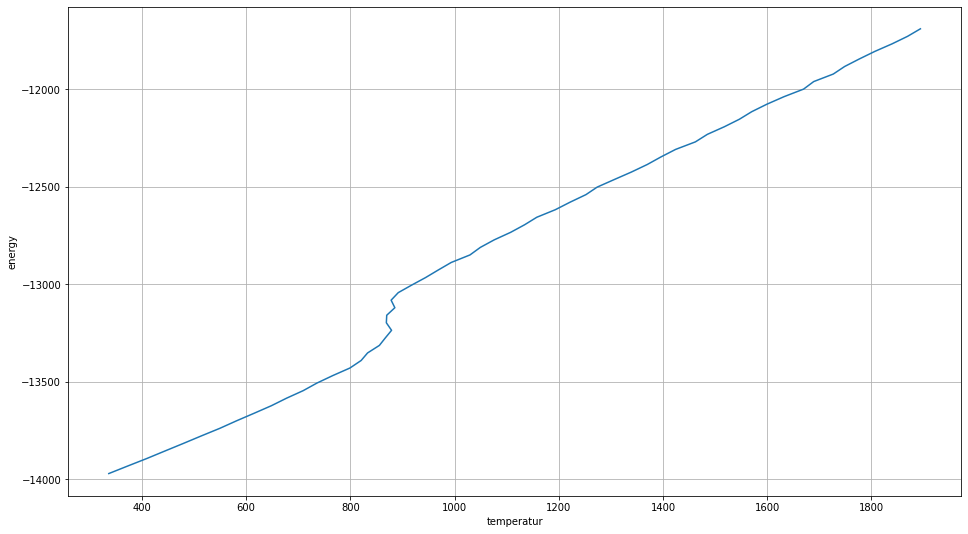

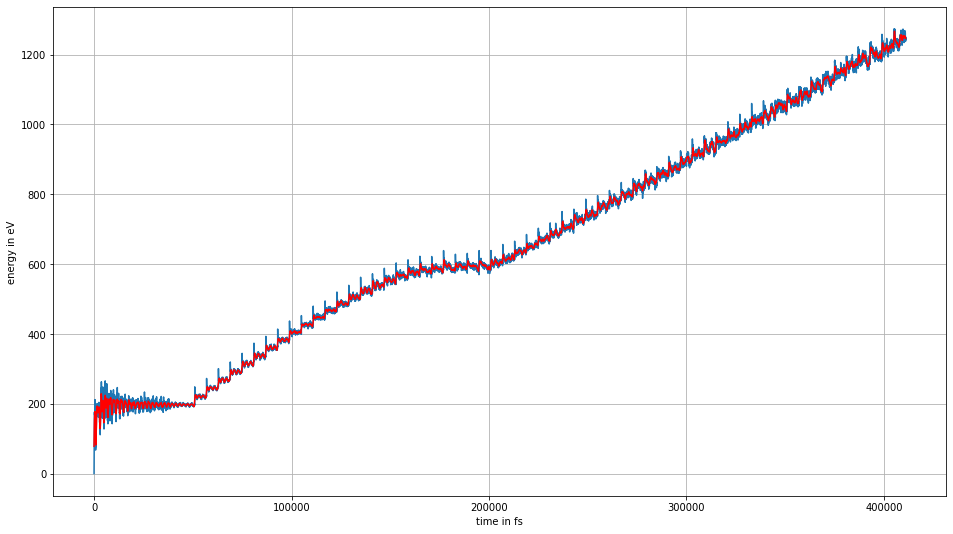

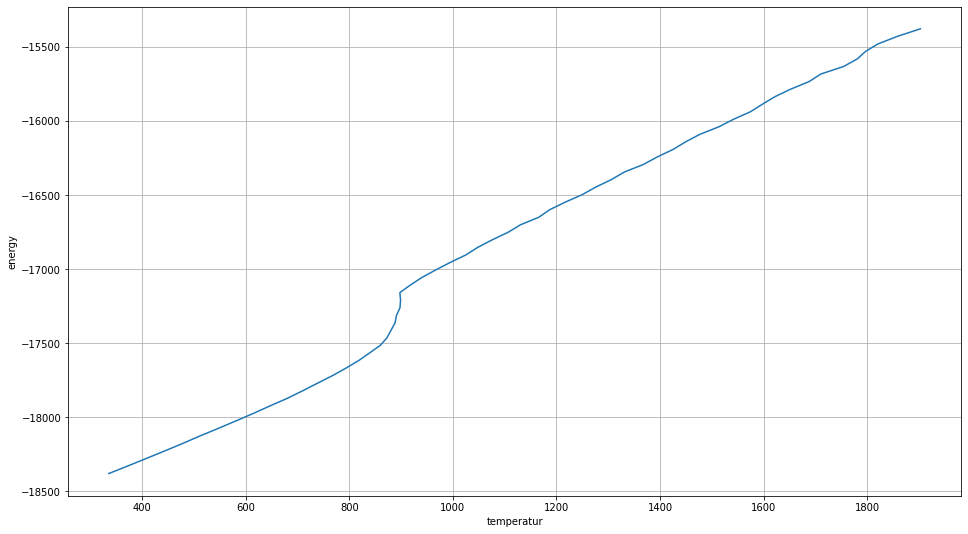

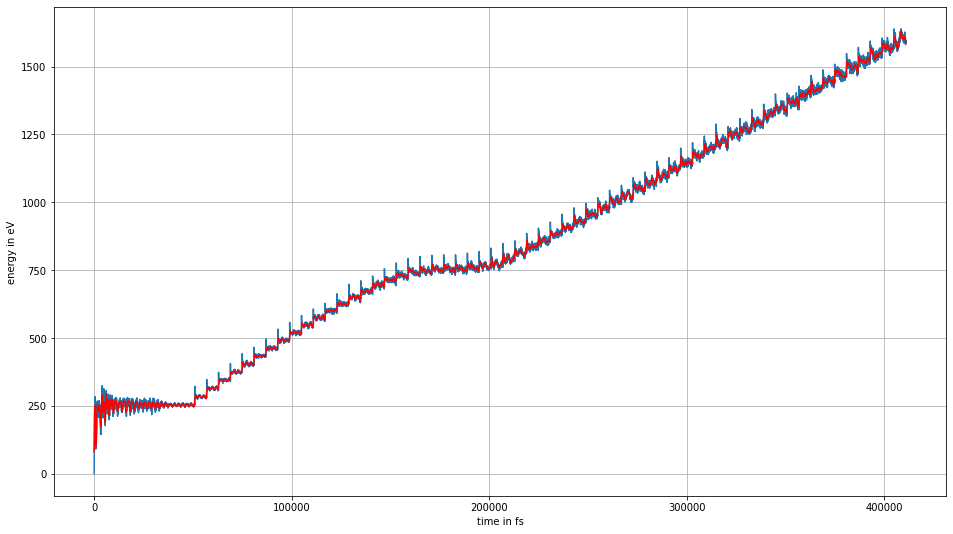

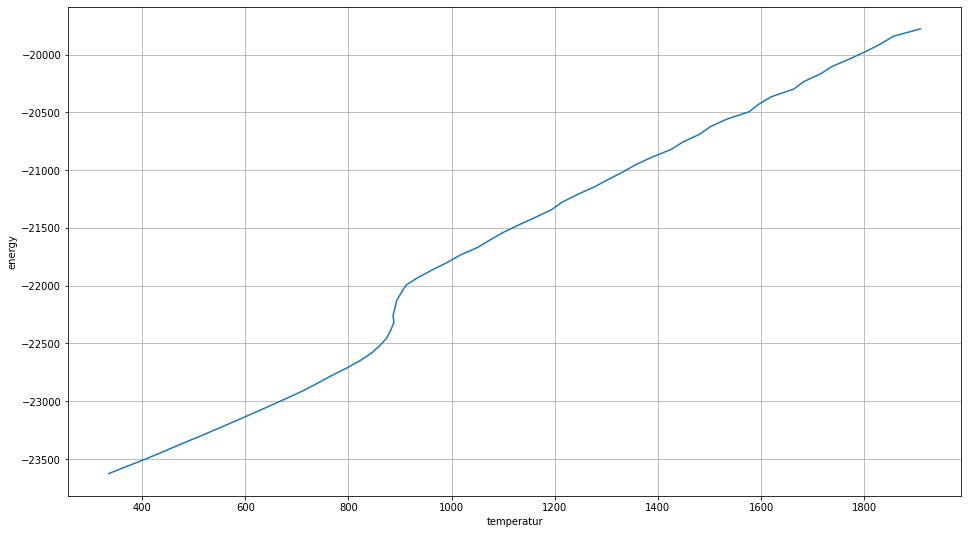

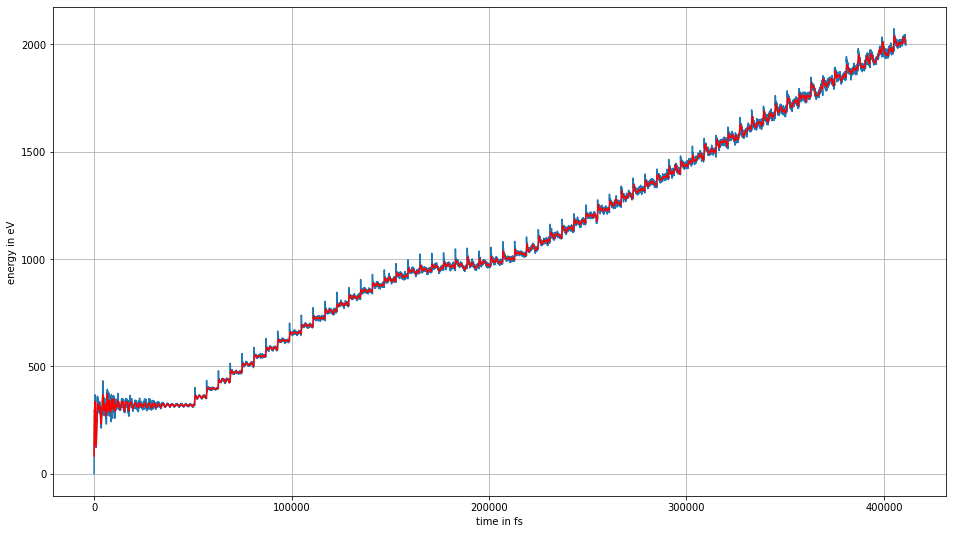

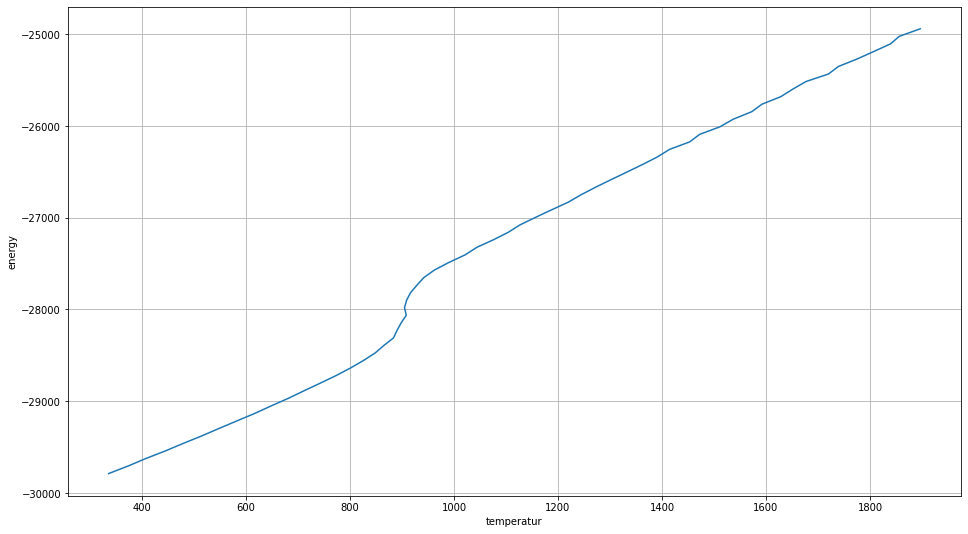

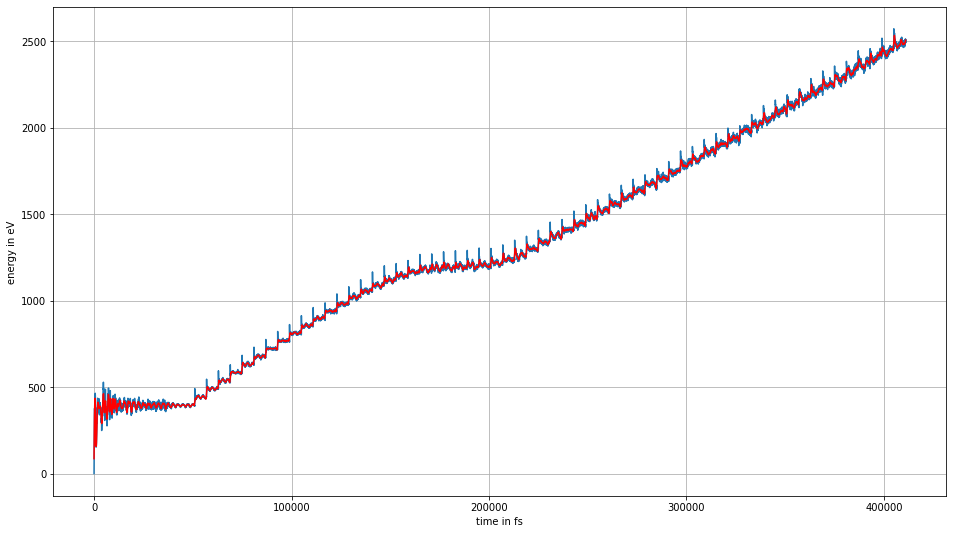

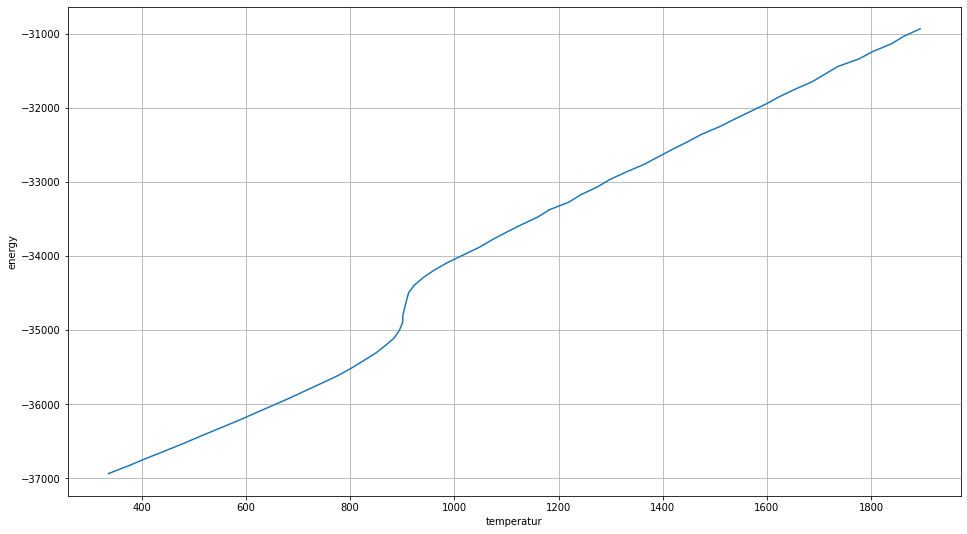

In [35]:
#Main  
#full program takes around 14 (22-8 couse i want to sleep) hours could be faster if no 13 and 14
#dataMaker()
plotter()

In [16]:
#Function Test
#plot data
#dataPlotterKineticEnergy(1)
#dataPlotterEnergyTemperatur(1)

In [ ]:
#incase the 13 and 14 take too long
for layerID in range(12-3+1):
        dataPlotterKineticEnergy(layerID+3)
        dataPlotterEnergyTemperatur(layerID+3)

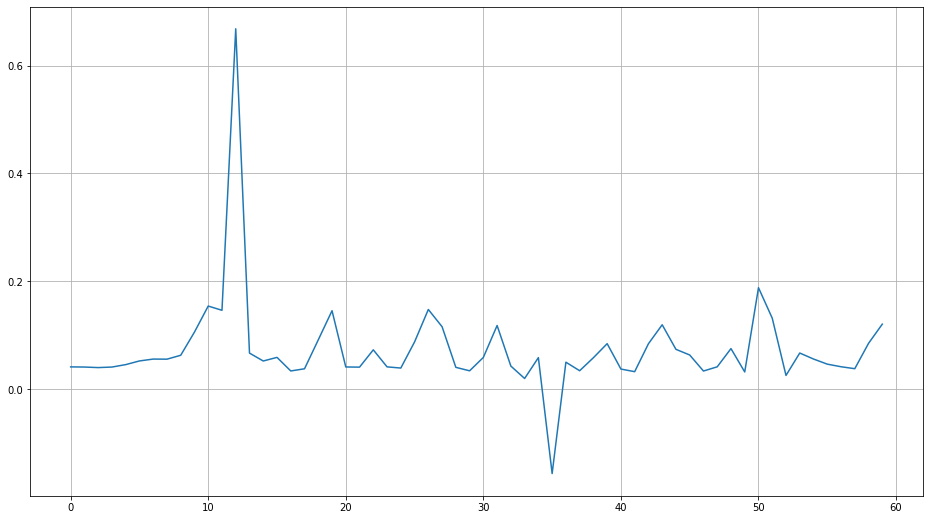

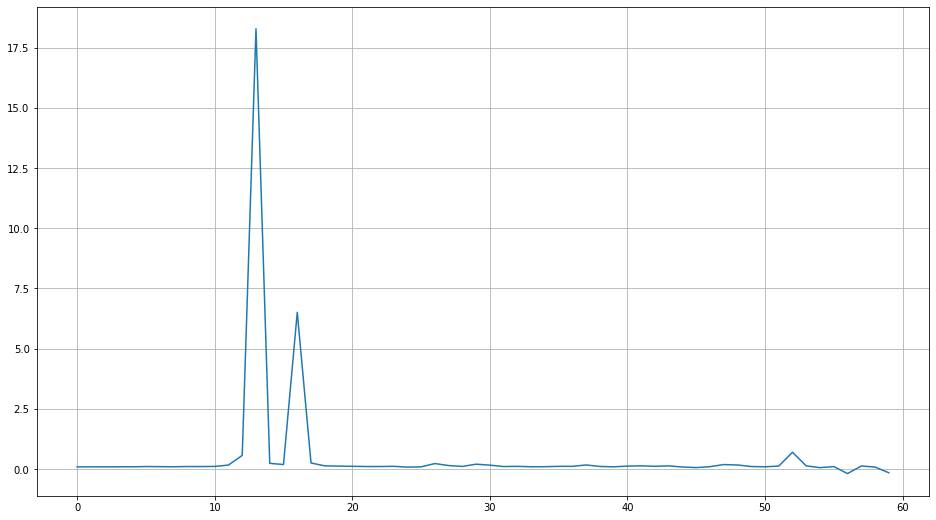

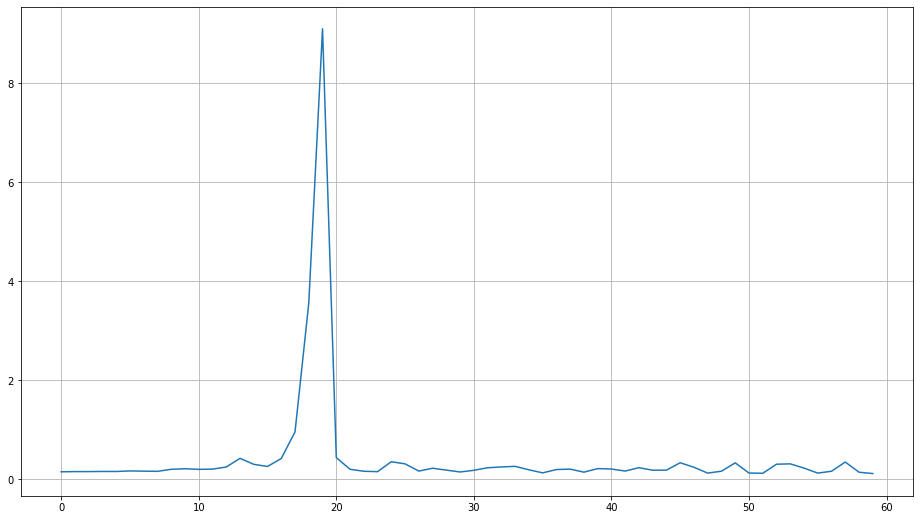

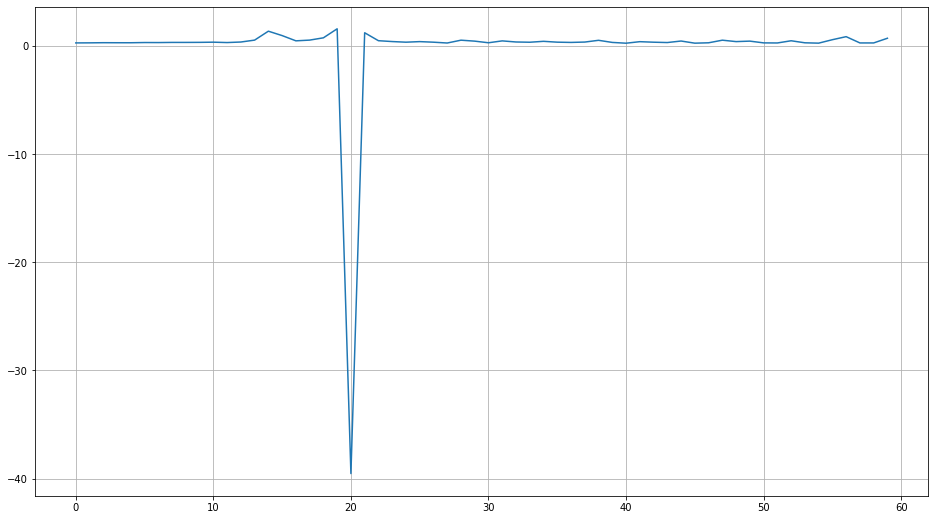

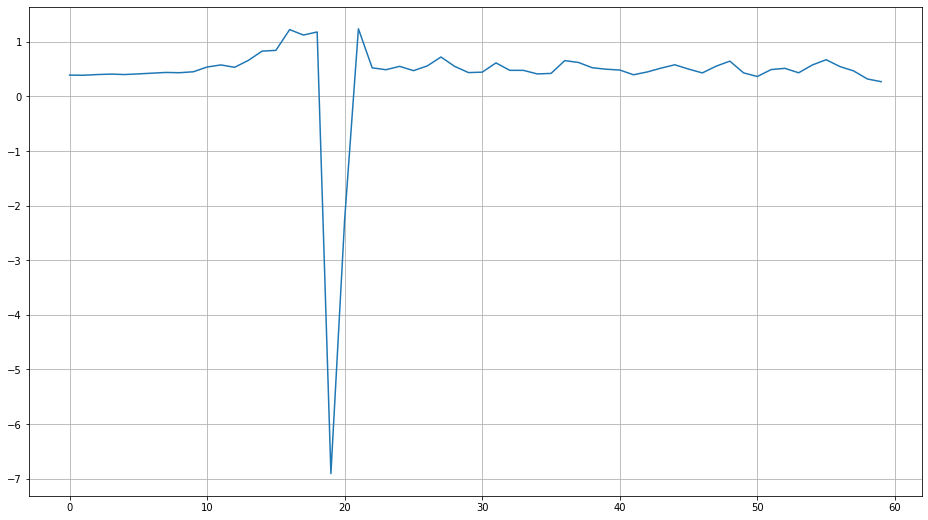

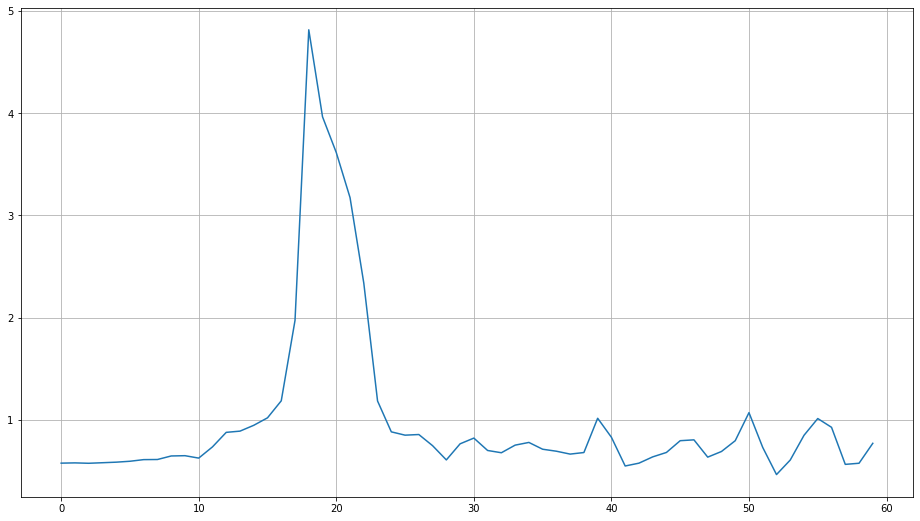

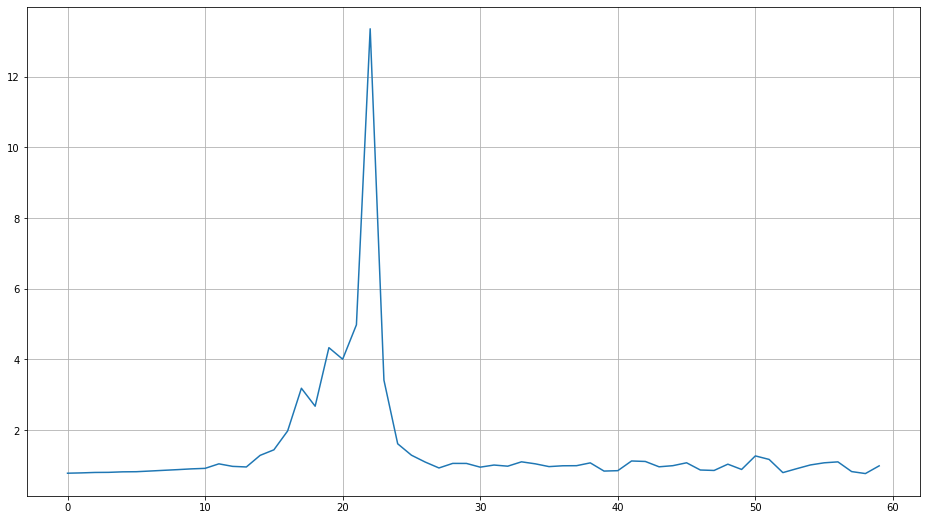

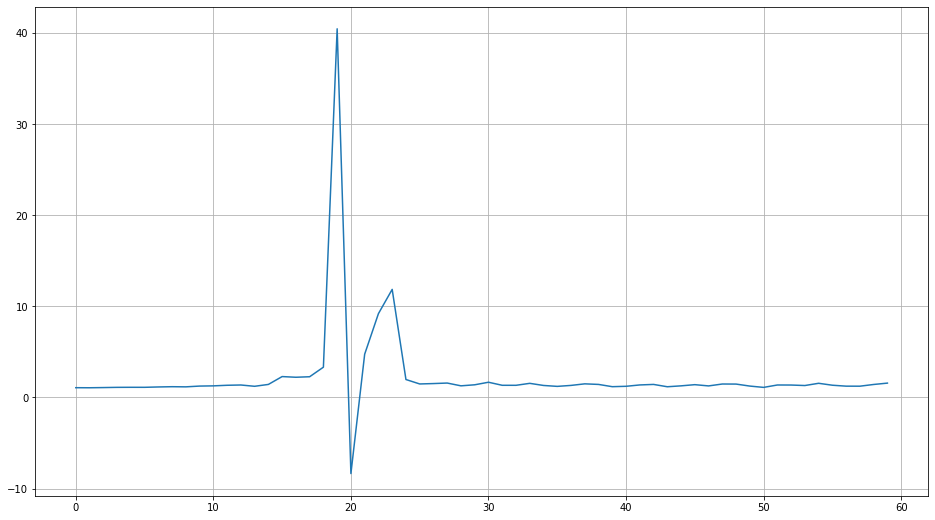

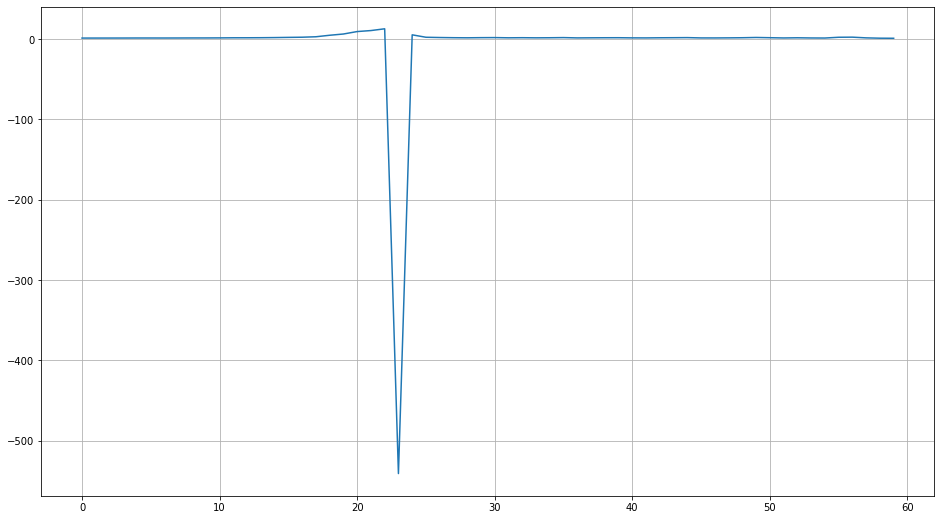

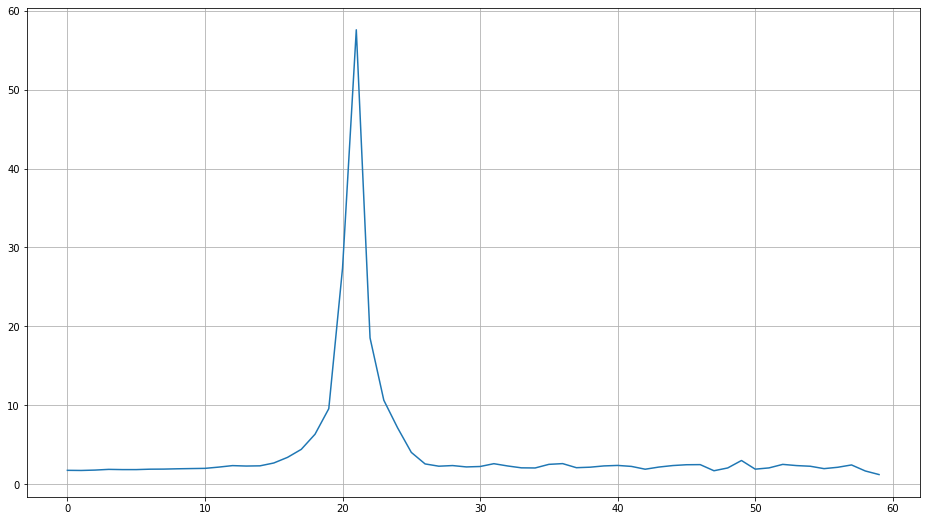

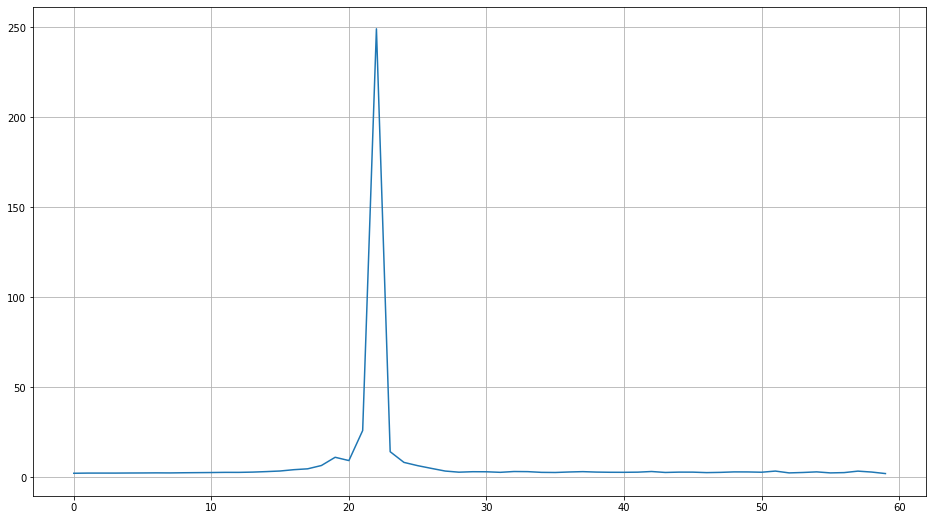

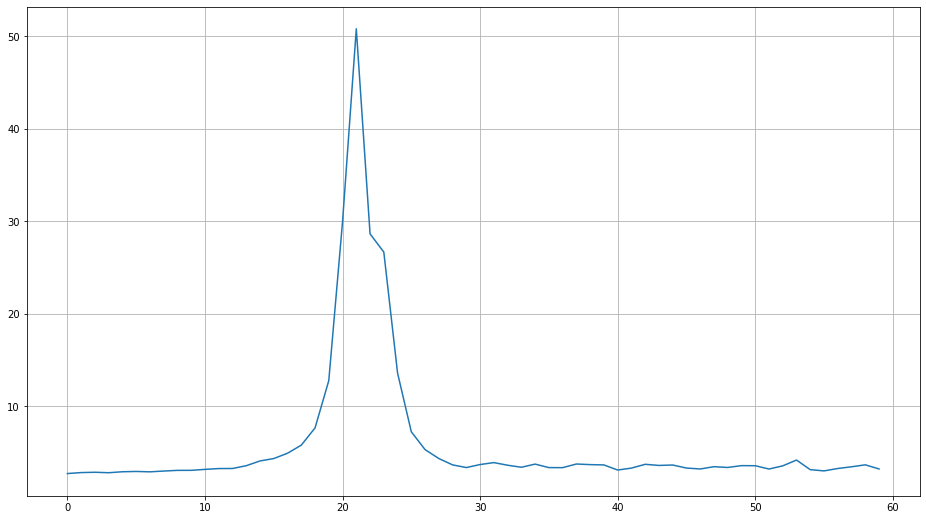

In [37]:
#gradient stuff
def dataPlotterDiffEnergyTemperatur(layerID):
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/temperaturEnergyCurveGradients" + str(layerID) + ".png"
    #open file
    file = open(energyFileLocation,'r')

    #read from the file
    text = file.readlines()
    energy = []
    for line in text:
        energy.append(float(line[:-1]))
    
    file.close()

    #open file
    file = open(temperaturFileLocation,'r')

    #read from the file
    text = file.readlines()
    temperatur = []
    for line in text:
        temperatur.append(float(line[:-1]))
    
    file.close()
    #####
    grad = np.gradient(energy)/np.gradient(temperatur)
      
    #plot
    plt.ion()
    plt.plot(grad)
    plt.grid()
    plt.savefig(imageSafeLocation)
    plt.show() 
    

for layerID in range(14-3+1):
    dataPlotterDiffEnergyTemperatur(layerID+3)